# Logistic Regression

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report

In [2]:
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import warnings
warnings.filterwarnings('ignore')

# Logistic regression on the titanic dataset- Part 1

The first thing we are going to do is to reade in the dataset using the panda's read_csv() function. We will put this data into a Pandas DataFrame, called "titanic",and name each of the columns.

In [3]:
url = 'data/titanic-train.csv'
titanic = pd.read_csv(url)
titanic.head()
titanic.shape

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


(891, 12)

# VARIABLE DESCRIPTIONS

Survived - Survival (0 = No; 1 = Yes)<br>
Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)<br>
Name - Name<br>
Sex - Sex<br>
Age - Age<br>
SibSp - Number of Siblings/Spouses Aboard<br>
Parch - Number of Parents/Children Aboard<br>
Ticket - Ticket Number<br>
Fare - Passenger Fare (British pound)<br>
Cabin - Cabin<br>
Embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

# Checking that your target variable is binary
Since we are building a model to predict survival of passangers from the Titanic, our target is going to be "Survived" variable from the titanic dataframe. To make sure that it's a binary variable, let's use Seaborn's countplot() function or you can use pd.groupby().count()

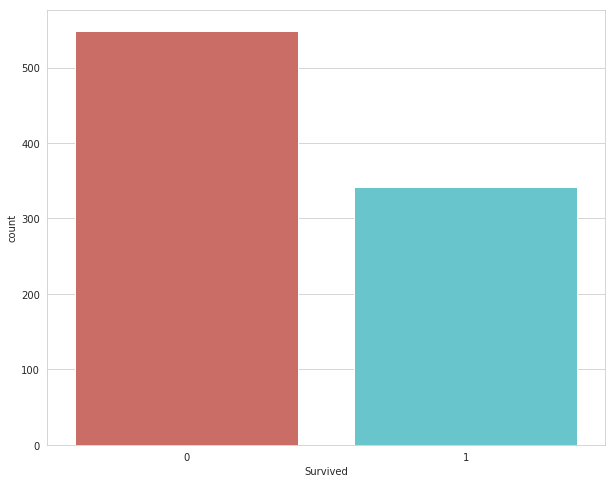

In [4]:
sb.countplot(x='Survived',data=titanic, palette='hls')

In [5]:
titanic.groupby('Survived').count()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Survived,,,,,,,,,,,
0,549,549,549,549,424,549,549,549,549,68,549
1,342,342,342,342,290,342,342,342,342,136,340


Ok, so we see that the Survived variable is binary (0 - did not survive / 1 - survived)

# Checking for missing values
It's easy to check for missing values by calling the isnull() method, and the sum() method off of that, to return a tally of all the True values that are returned by the isnull() method.

In [6]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Well, how many records are there in the data frame anyway?

In [7]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Ok, so there are only 891 rows in the titanic data frame. Cabin is almost all missing values, so we can drop that variable completely, but what about age? Age seems like a relevant predictor for survival right? We'd want to keep the variables, but it has 177 missing values. Yikes!! We are going to need to find a way to approximate for those missing values!

# Logistic regression on the titanic dataset- Part 2

# Taking care of missing values
# Dropping missing values
So let's just go ahead and drop all the variables that aren't relevant for predicting survival. We should at least keep the following:

- Survived - This variable is obviously relevant.
- Pclass - Does a passenger's class on the boat affect their survivability?
- Sex - Could a passenger's gender impact their survival rate?
- Age - Does a person's age impact their survival rate?
- SibSp - Does the number of relatives on the boat (that are siblings or a spouse) affect a person survivability? Probably
- Parch - Does the number of relatives on the boat (that are children or parents) affect a person survivability? Probably
- Fare - Does the fare a person paid effect his survivability? Maybe - let's keep it.
- Embarked - Does a person's point of embarkation matter? It depends on how the boat was filled... Let's keep it.

What about a person's name, ticket number, and passenger ID number? They're irrelevant for predicting survivability. And as you recall, the cabin variable is almost all missing values, so we can just drop all of these.

In [9]:
titanic_data = titanic.drop(['PassengerId','Name','Ticket','Cabin'],1)
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Now we have the dataframe reduced down to only relevant variables, but now we need to deal with the missing values in the age variable.

# Imputing missing values
Let's look at how passenger age is related to their class as a passenger on the boat.

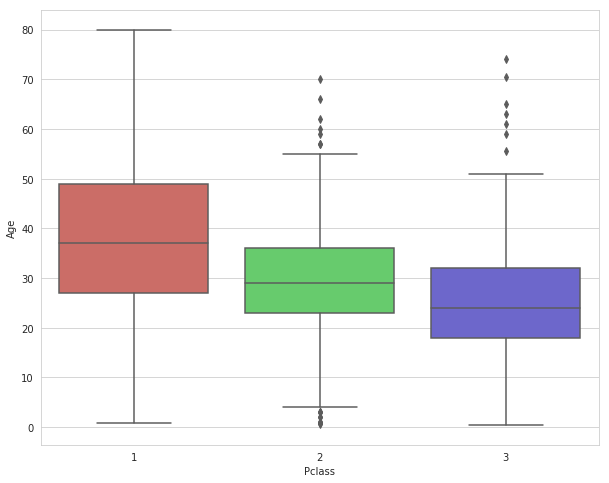

In [11]:
sb.boxplot(x='Pclass',y='Age',data=titanic_data,palette='hls')


In [12]:
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Speaking roughly, we could say that the younger a passenger is, the more likely it is for them to be in 3rd class. The older a passenger is, the more likely it is for them to be in 1st class. So there is a loose relationship between these variables. So, let's write a function that approximates a passengers age, based on their class. From the box plot, it looks like the average age of 1st class passengers is about 37, 2nd class passengers is 29, and 3rd class pasengers is 24.

So let's write a function that finds each null value in the Age variable, and for each null, checks the value of the Pclass and assigns an age value according to the median age of passengers in that class.

In [14]:
def age_approx(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        if Pclass == 2:
            return 29
        if Pclass == 3:
            return 24
    else:
        return Age

When we apply the function and check again for null values, we see that there are no more null values in the age variable.

In [15]:
titanic_data['Age'] = titanic_data[['Age','Pclass']].apply(age_approx,axis=1)
titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

There are 2 null values in the embarked variable. We can drop those 2 records without loosing too much important information from our dataset, so we will do that.

In [17]:
titanic_data.dropna(inplace=True)
titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [19]:
titanic_data.shape

(889, 8)

# Take a look on get_dummies() function

In [20]:
# Convert categorical variable into dummy/indicator variables
df = pd.DataFrame({'A': ['a', 'b', 'a'], 'B': ['b', 'a', 'c'],
                   'C': [1, 2, 3]})

In [21]:
pd.get_dummies(pd.Series(list('abcaa')))

,a,b,c
0,1,0,0
1,0,1,0
2,0,0,1
3,1,0,0
4,1,0,0


In [22]:
pd.get_dummies(pd.Series(list('abcaa')),drop_first=True)

,b,c
0,0,0
1,1,0
2,0,1
3,0,0
4,0,0
